In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=5
%env DWAVE_API_TOKEN=DEV-1ba72787de429d2af12464f7753c10b9ff6945ad
%config InlineBackend.figure_format = 'retina'
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: DWAVE_API_TOKEN=DEV-1ba72787de429d2af12464f7753c10b9ff6945ad
Fri Jun 21 22:29:41 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:1B:00.0 Off |                  Off |
| 30%   42C    P2             91W /  300W |    8892MiB /  49140MiB |     35%      Default |
|                                       

In [2]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/CaloQVAE/')

#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[22:29:44.771] INFO   CaloQVAE                                          Willkommen!
[22:29:44.772] INFO   CaloQVAE                                          Loading configuration.


In [3]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_photons = HLF('photon', filename='/fast_scratch_1/caloqvae/data/atlas/binning_dataset_1_photons.xml', wandb=False)
HLF_1_pions = HLF('pion', filename='/fast_scratch_1/caloqvae/data/atlas/binning_dataset_1_pions.xml', wandb=False)
HLF_1_electron = HLF('electron', filename='/fast_scratch_1/caloqvae/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

[22:29:46.170] INFO   numexpr.utils                                     Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[22:29:46.172] INFO   numexpr.utils                                     Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[22:29:46.173] INFO   numexpr.utils                                     NumExpr defaulting to 8 threads.
2024-06-21 22:29:46,756 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[22:29:46.756] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0


In [4]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")

hydra.initialize()

In [5]:
# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/usr/local/lib/python3.10/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[22:29:48.922] INFO   data.dataManager                                  Loading Data
[22:30:09.465] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f93337ef040>: 80000 events, 625 batches
[22:30:09.467] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f93efcbce20>: 10000 events, 10 batches
[22:30:09.468] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f93efcbd930>: 10000 events, 10 batches
[22:30:11.631] INFO   models.modelCreator                               Initialising Model Type AtlasConditionalQVAEv2
2024-06-21 22:30:11,645 dwav

Initializing NetworkV3
Initializing NetworkV3
Initializing NetworkV3
Initializing NetworkV3
Initializing NetworkV3


In [6]:


# dev = torch.device("cuda:0")
dev = "cuda:{0}".format(config.gpu_list[0])
wandb.watch(model)
engine=instantiate(config.engine, config)
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[22:30:18.292] INFO   wandb                                             Watching
/home/luian1/.local/lib/python3.10/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
[22:30:18.753] INFO   engine.engineAtlas                                Setting up engine Atlas.
[22:30:18.754] INFO   engine.engineCaloV3                               Setting up engine Calo.
[22:30:18.755] INFO   engine.engine                                     Setting up default engine.


In [7]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[22:30:40.222] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f93337eee00>: 80000 events, 625 batches
[22:30:40.224] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f93337eed10>: 10000 events, 10 batches
[22:30:40.226] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f93337eea70>: 10000 events, 10 batches


In [8]:
def load_state(model, run_path, device):
        model_loc = run_path
        
        # Open a file in read-binary mode
        with open(model_loc, 'rb') as f:
            # Interpret the file using torch.load()
            checkpoint=torch.load(f, map_location=device)
            
            local_module_keys=list(model._modules.keys())
            print(local_module_keys)
            for module in checkpoint.keys():
                if module in local_module_keys:
                    print("Loading weights for module = ", module)
                    getattr(model, module).load_state_dict(checkpoint[module])

In [9]:
# winter-snowflake-24: GumBoltAtlasPRBMCNN
# run_path = "/fast_scratch/sgonzalez/wandb/run-20240228_120832-q78nzust/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"

# run_path = "/fast_scratch/sgonzalez/wandb/run-20240313_155921-4q9i8pnt/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'macabre-candle-1372'
# datascaled = 'scaled'
# with open("/fast_scratch/sgonzalez/wandb/run-20240313_155921-4q9i8pnt/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     #R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     #reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False

# change this directory to load the synthetic data

# run_path = "/fast_scratch/QVAE/syn_data/dataset2_synthetic_macabre-candle-1372v2.hdf5"

# run_path = "/fast_scratch_1/caloqvae/luian1/wandb/run-20240620_223442-7ggy3s19/files/AtlasConditionalQVAEv2_atlas_default_best.pth"
# modelname = 'dutiful-silence-108'
# datascaled = 'scaled'
# with open("/fast_scratch_1/caloqvae/luian1/wandb/run-20240620_223442-7ggy3s19/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     #R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     #reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False


# arch = config['model']['model_type']
# part = config['data']['particle_type']
# print(arch)
# print(part)


# # load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
# load_state(model, run_path, dev)
# model.eval();

#pretty-shape-455 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
run_path = "/fast_scratch_1/caloqvae/luian1/wandb/run-20240620_223442-7ggy3s19/files/AtlasConditionalQVAEv2_atlas_default_best.pth"
modelname = 'dutiful-silence-108'
datascaled = 'reduced'
with open("/fast_scratch_1/caloqvae/luian1/wandb/run-20240620_223442-7ggy3s19/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=False


    
arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)
print(scaled, reducedata)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
# load_state(model, run_path, dev)
modelCreator.load_state(run_path, dev)
engine.model.eval();

[22:30:40.252] INFO   models.modelCreator                               Loading state


AtlasConditionalQVAEv2
electron-ds2
False True


[22:30:41.036] INFO   models.modelCreator                               Loading weights from file : /fast_scratch_1/caloqvae/luian1/wandb/run-20240620_223442-7ggy3s19/files/AtlasConditionalQVAEv2_atlas_default_best.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder


In [10]:
# engine.con

# Test data: /fast_scratch/QVAE/test_data/dataset_2_2.hdf5
# Synthetic data: /fast_scratch/QVAE/syn_data/dataset2_synthetic_macabre-candle-1372v2.hdf5

In [11]:
# xtarget_samples = []
# xrecon_samples = []
# xgen_samples = []
# scaled = False
# entarget_samples = [] #in MeV

# def itr_merge(*itrs):
#     for itr in itrs:
#         for v in itr:
#             yield v
            
# # for xx in train_loader:
# for xx in val_loader:
#     in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    
#     fwd_output = engine.model((in_data, true_energy), False)
    
#     if scaled:
#         in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
        
        
#         recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
        
#         ## This is how youi generate data using model
#         # ================================
#         engine._model.sampler._batch_size = true_energy.shape[0]
#         sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy) #engine._model.generate_samples_qpu(num_samples=128, true_energy=true_energy[:128])
#         engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
#         sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
#         # ================================
    
#     else:
#         raise Exception("Script only supports scaled dataset at the moment...")


#     xtarget_samples.append(in_data.detach().cpu())
#     xrecon_samples.append( recon_data.detach().cpu())
#     xgen_samples.append( sample_data.detach().cpu())
#     entarget_samples.append(true_energy.detach().cpu())
    
# # use these
# xtarget_samples = torch.cat(xtarget_samples, dim=0)
# xrecon_samples = torch.cat(xrecon_samples, dim=0)
# xgen_samples = torch.cat(xgen_samples, dim=0)
# entarget_samples = torch.cat(entarget_samples, dim=0)

In [12]:

partition_size=config.model.n_latent_nodes_per_p
encoded_data = []
energy_encoded_data = []
n_samples4_qpu = 200

# encoded_data_rdm = []
# energy_encoded_data_rdm = []
engine.model.eval()
# engine_2.model.eval()
with torch.no_grad():
    for xx in val_loader:
    # for xx in train_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        #################################################
        # true_energy = true_energy[:n_samples4_qpu,:]
        # in_data = in_data[:n_samples4_qpu,:]
        #################################################
        if reducedata:
            in_data = engine._reduce(in_data, true_energy, R=R)
        # enIn = torch.cat((in_data, true_energy), dim=1)
        # beta, post_logits, post_samples = engine.model.encoder(enIn, False)
        beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy, False)
        post_samples = torch.cat(post_samples, 1)
        post_samples_energy = engine.model.stater.energy_samples(post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], 
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size], 1.0 )
        encoded_data.append(post_samples.detach().cpu())
        energy_encoded_data.append(post_samples_energy.detach().cpu())
        
        # #Rdm model
        # # enIn = torch.cat((in_data, true_energy), dim=1)
        # # beta, post_logits, post_samples = engine.model.encoder(enIn, False)
        # beta, post_logits, post_samples = engine_2.model.encoder(in_data, true_energy, False)
        # post_samples = torch.cat(post_samples, 1)
        # post_samples_energy = engine_2.model.stater.energy_samples(post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], 
        #                                          post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size], 1.0 )
        # encoded_data_rdm.append(post_samples.detach().cpu())
        # energy_encoded_data_rdm.append(post_samples_energy.detach().cpu())

encoded_data = torch.cat(encoded_data, dim=0)
energy_encoded_data = torch.cat(energy_encoded_data, dim=0)
        
# encoded_data_rdm = torch.cat(encoded_data_rdm, dim=0)
# energy_encoded_data_rdm = torch.cat(energy_encoded_data_rdm, dim=0)

p1,p2,p3,p4 = post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], \
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size]

energy_rbm_data = []
rbm_data = []
# energy_rbm_rdm_data = []
with torch.no_grad():
    # for i in range(10):
    for xx in val_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        ##################################################
        # true_energy = true_energy[:n_samples4_qpu,:]
        # in_data = in_data[:n_samples4_qpu,:]
        ##################################################
        # if i == 0:
            # p1, p2, p3, p4 = engine.model.stater.block_gibbs_sampling_ais(1.0)
        # else:
            # p1, p2, p3, p4 = engine.model.stater.block_gibbs_sampling_ais(1.0, p1, p2, p3, p4)
        engine._model.sampler._batch_size = true_energy.shape[0]
        if True:
            u = engine.model.encoder.binary_energy(true_energy).to(dtype=torch.float32)
            p1, p2, p3, p4 = engine.model.sampler.block_gibbs_sampling_cond(u)
        else:
            p1, p2, p3, p4 = engine.model.sampler.block_gibbs_sampling()
        rbm_data.append(torch.cat((p1,p2,p3,p4),1))
        rbm_samples_energy = engine.model.stater.energy_samples(p1, p2, p3, p4, 1.0)
        energy_rbm_data.append(rbm_samples_energy.detach().cpu())
        engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
        
        # if i == 0:
        #     p1_r, p2_r, p3_r, p4_r = engine_2.model.stater.block_gibbs_sampling_ais(1.0)
        # else:
        #     p1_r, p2_r, p3_r, p4_r = engine_2.model.stater.block_gibbs_sampling_ais(1.0, p1_r, p2_r, p3_r, p4_r)
        # rbm_rdm_samples_energy = engine_2.model.stater.energy_samples(p1_r, p2_r, p3_r, p4_r, 1.0)
        # energy_rbm_rdm_data.append(rbm_rdm_samples_energy.detach().cpu())
    
energy_rbm_data = torch.cat(energy_rbm_data, dim=0)
rbm_data = torch.cat(rbm_data,0)
# energy_rbm_rdm_data = torch.cat(energy_rbm_rdm_data, dim=0)

In [13]:
# en_labels = []

xtarget_samples = []
xrecon_samples = []
xgen_samples = []
xgen_samples_qpu = []
n_samples4_qpu = 200

# xrecon_samples_2 = []

# labelstarget_samples = []
# labelsrecon_samples = []
entarget_samples = []
with torch.no_grad():
    for xx in val_loader:
    # for xx in train_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        ###############################################
        # true_energy = true_energy[:n_samples4_qpu,:]
        # in_data = in_data[:n_samples4_qpu,:]
        ##############################################
        # print(in_data.shape)
        if reducedata:
            in_data = engine._reduce(in_data, true_energy, R=R)
        fwd_output = engine.model((in_data, true_energy), False)
        if reducedata:
            in_data = engine._reduceinv(in_data, true_energy, R=R)
            recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
            engine._model.sampler._batch_size = true_energy.shape[0]
            if True:
                sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy, num_samples=1, thrsh=30, beta=1/beta0)
            else:
                sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
            # sample_data_qpu = engine._reduceinv(sample_data_qpu, sample_energies_qpu, R=R)
        elif scaled:
            in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
            recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
            # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_just_act.detach().cpu().numpy()))
            # recon_data_2 = torch.tensor(engine._data_mgr.inv_transform(fwd_energy_shift.detach().cpu().numpy()))
            engine._model.sampler._batch_size = true_energy.shape[0]
            
            if True:
                sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                # sample_energies_qpu, sample_data_qpu = engine.model.generate_samples_qpu_cond(true_energy=true_energy[:100,:], num_samples=1, thrsh=30, beta=1/beta0)
            else:
                sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
                # sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta0)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
            # sample_data_qpu = torch.tensor(engine._data_mgr.inv_transform(sample_data_qpu.detach().cpu().numpy()))
        else:
            in_data = in_data.detach().cpu()*1000
            recon_data = fwd_output.output_activations.detach().cpu()*1000
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
            sample_data = sample_data.detach().cpu()*1000


        xtarget_samples.append(in_data.detach().cpu())
        xrecon_samples.append( recon_data.detach().cpu())
        xgen_samples.append( sample_data.detach().cpu())
        # xgen_samples_qpu.append( sample_data_qpu.detach().cpu())
        entarget_samples.append(true_energy.detach().cpu())

        # xrecon_samples_2.append( recon_data_2.detach().cpu())
    
    
xtarget_samples = torch.cat(xtarget_samples, dim=0)
xrecon_samples = torch.cat(xrecon_samples, dim=0)
xgen_samples = torch.cat(xgen_samples, dim=0)
# xgen_samples_qpu = torch.cat(xgen_samples_qpu, dim=0)
entarget_samples = torch.cat(entarget_samples, dim=0)

# xrecon_samples_2 = torch.cat(xrecon_samples_2, dim=0)

In [14]:
xtarget_samples_orig = xtarget_samples
entarget_samples_orig = entarget_samples
print(xtarget_samples, xtarget_samples.shape)

tensor([[ 2.8870,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [25.4611,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  8.4747,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 2.6255, 33.7257, 21.9538,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  2.8941,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.4203,  ...,  0.0000,  0.0000,  0.0000]]) torch.Size([10000, 6480])


In [15]:
import h5py

# New test data
test_data = h5py.File('/fast_scratch_1/caloqvae/test_data/dataset_2_2.hdf5', 'r')
print(test_data.keys())
print(test_data['incident_energies'].shape)
print(test_data['showers'].shape)

<KeysViewHDF5 ['incident_energies', 'showers']>
(100000, 1)
(100000, 6480)


In [16]:
data_showers = (np.array(test_data['showers']))
data_showers = torch.tensor(data_showers)
print(data_showers, data_showers.shape)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 2.2734,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 3.4687,  0.0000, 12.4008,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  2.4727,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       dtype=torch.float64) torch.Size([100000, 6480])


In [17]:
# Data from good model
# gen_samps = h5py.File('/fast_scratch_1/caloqvae/syn_data/wise-tree-1429.hdf5', 'r')
gen_samps = h5py.File('/fast_scratch_1/caloqvae/syn_data/dataset2_synthetic_honest-hill-454.hdf5', 'r')
print(len(gen_samps))
print(gen_samps.keys())
print((gen_samps['incidence energy']).shape)
print((gen_samps['showers']).shape)
print(xtarget_samples.numpy().shape)
factor = (xtarget_samples.numpy().shape)[0]/((gen_samps['showers']).shape)[0]
print(factor)

2
<KeysViewHDF5 ['incidence energy', 'showers']>
(100000, 1)
(100000, 6480)
(10000, 6480)
0.1


In [18]:
entarget_samples = torch.tensor(gen_samps['incidence energy'])
xgen_samples_1429 = (torch.tensor(gen_samps['showers']))
print(xgen_samples, xgen_samples.shape)
print(xgen_samples_1429, xgen_samples_1429.shape)
print(np.histogram((xgen_samples_1429 == 0).sum(dim=1) / xtarget_samples.shape[1], bins=20))

/tmp/ipykernel_2352976/610735836.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:276.)
  entarget_samples = torch.tensor(gen_samps['incidence energy'])


tensor([[ 8.1322,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.0901,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [17.8141,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000, 20.4710,  ..., 10.2480,  7.7571,  0.0000],
        [14.1079, 16.2831,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9235,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]) torch.Size([10000, 6480])
tensor([[13.4593,  0.0000,  0.0000,  ...,  0.0000, 10.6332,  0.0000],
        [22.4145,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000, 15.8354,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 4.9879,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]) torch.Size([100000, 6480])
(array([ 1124,  3123,  2260,  2748,  2697,  2218,  2695,  2613,  2783,
        

In [19]:
xtarget_samples = data_showers

In [20]:
hfont = {'fontname':'Helvetica'}
ds = {'electron-ds2':'Dataset 2', 'pion1':'Dataset 1: π'}

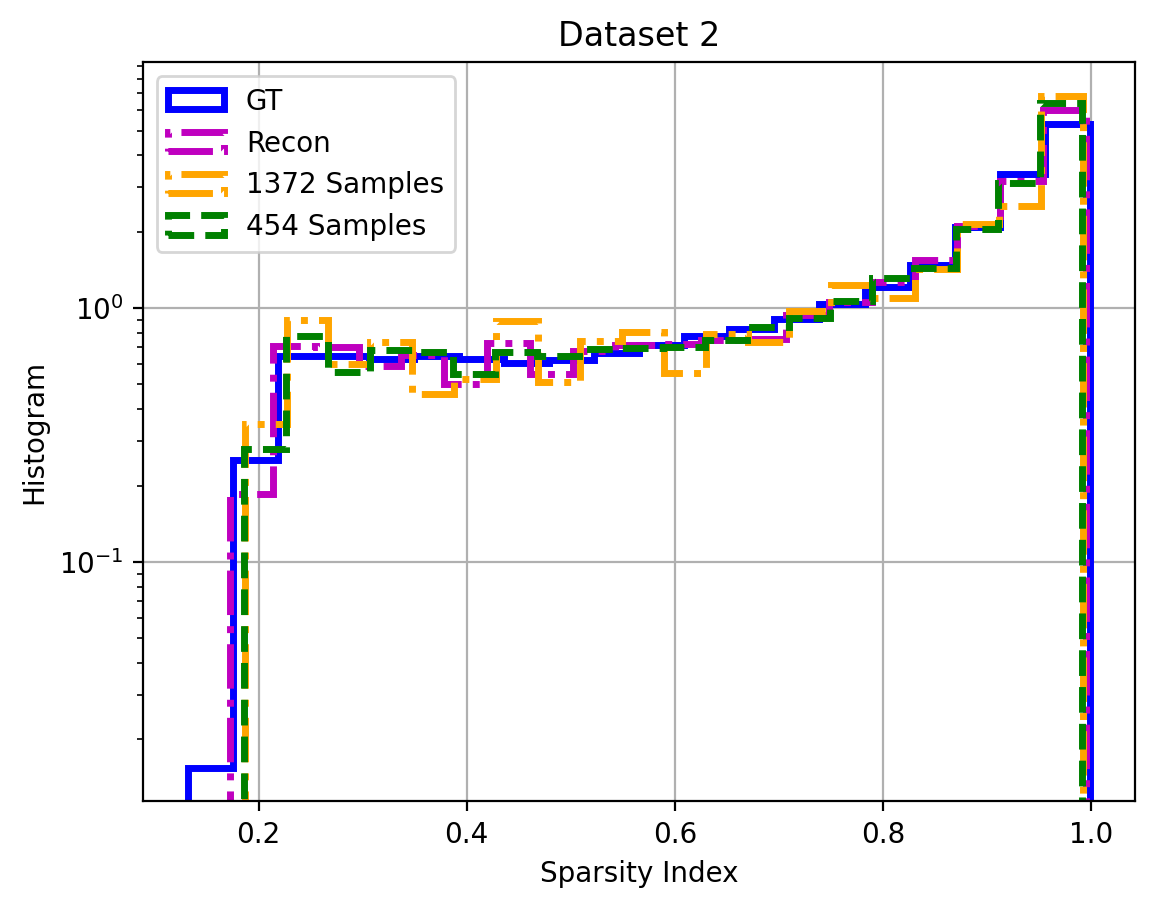

In [21]:
plt.hist(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, density=True, histtype='step', linewidth=2.5, color="b")
plt.hist(((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, density=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(((xgen_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, density=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot")
plt.hist((xgen_samples_1429 == 0).sum(dim=1) / xtarget_samples.shape[1], bins=20, log=True, density=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")
# plt.hist(((xgen_samples_1429 == 0).sum(axis=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot")

plt.xlabel("Sparsity Index")
plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "1372 Samples", "454 Samples"])
plt.title(f'{ds[part]}')
plt.grid("True")
plt.show()

720 0
1440 720
2160 1440
2880 2160
3600 2880
4320 3600
5040 4320
5760 5040
6480 5760


<Figure size 800x600 with 0 Axes>

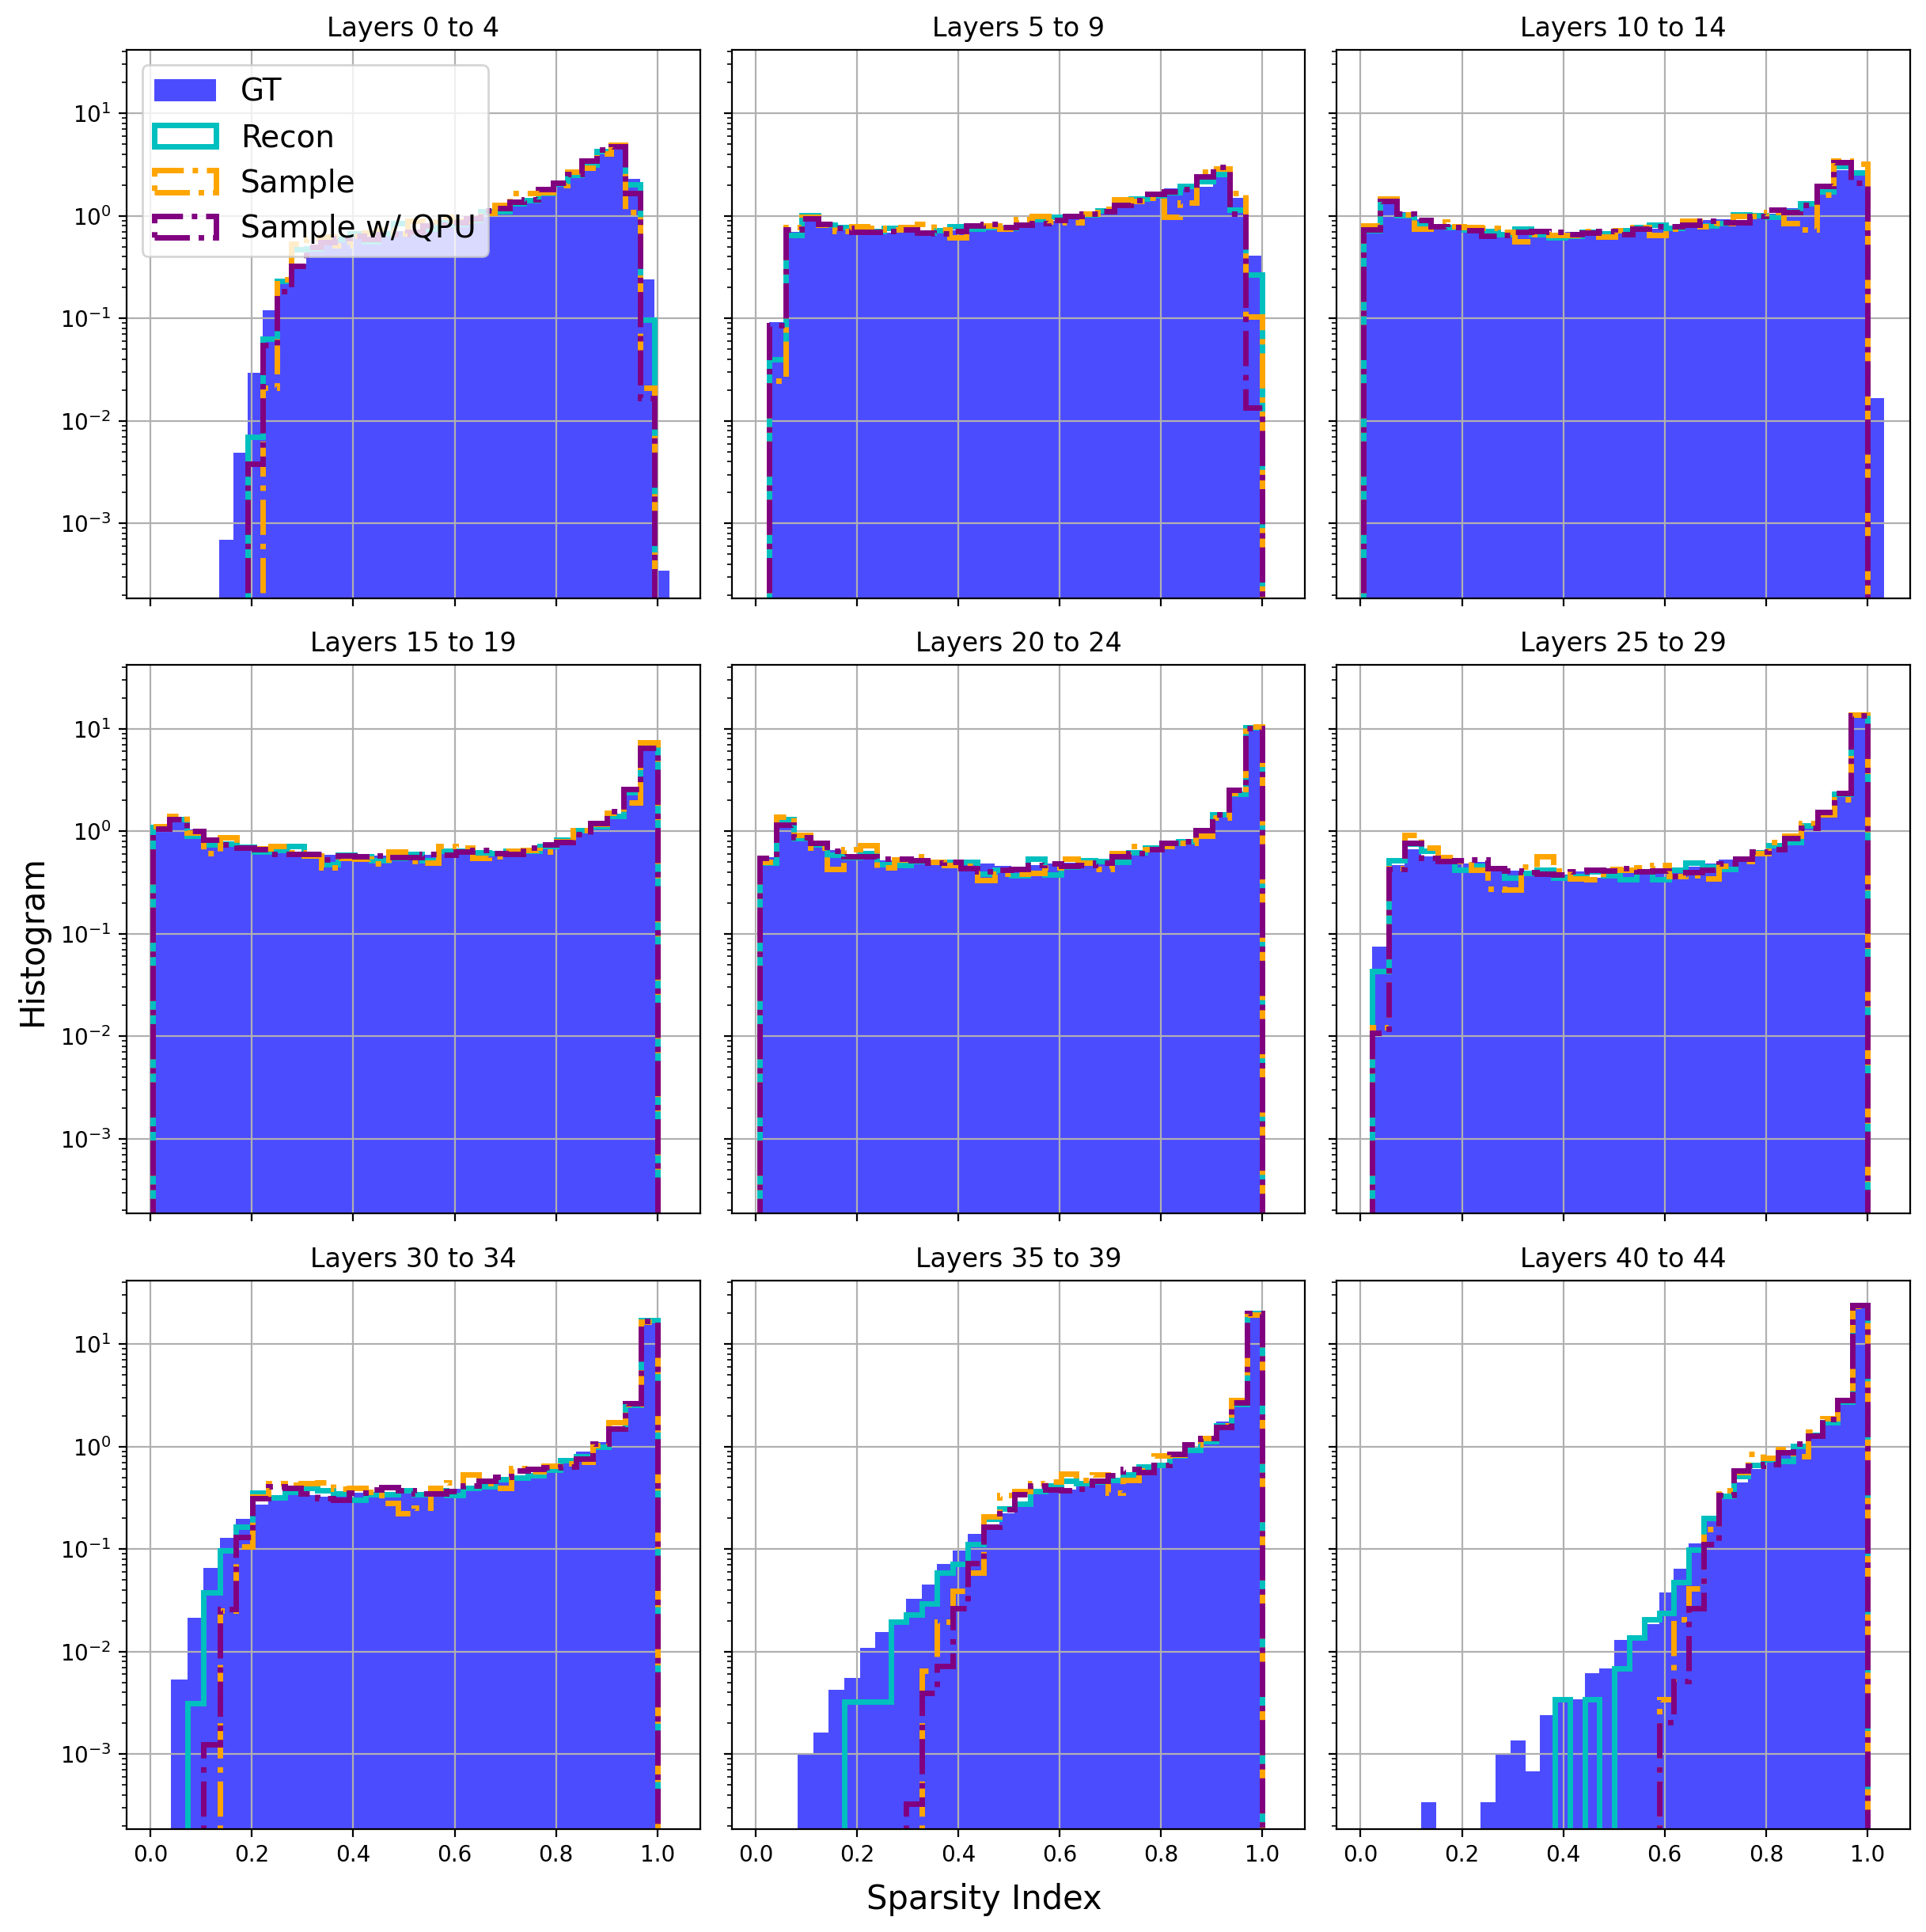

In [22]:
import os
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]

# Create lists for the histogram values
target_counts, recon_counts, sample_counts = [0] * (len(HLF_1_electron.relevantLayers) - 1), [0] * (len(HLF_1_electron.relevantLayers) - 1), [0] * (len(HLF_1_electron.relevantLayers) - 1)
target_bins, recon_bins, sample_bins = [0] * (len(HLF_1_electron.relevantLayers) - 1), [0] * (len(HLF_1_electron.relevantLayers) - 1), [0] * (len(HLF_1_electron.relevantLayers) - 1)

plt.figure(figsize=(8,6))
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=True, tight_layout=True)
fig.text(0.5, -0.01, 'Sparsity Index', ha='center', fontsize=15)
fig.text(-0.01, 0.5, 'Histogram', va='center', rotation='vertical', fontsize=15)

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    print(idx, idxPrev)
    minVal, maxVal = min(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy()), max(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy())
    binwidth = (maxVal-minVal)/30
    
    # Store the values of the histogram with the same normalization and bin sizes
    target_counts[i], target_bins[i] = np.histogram(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth))
    recon_counts[i], recon_bins[i] = np.histogram(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth))
    sample_counts[i], sample_bins[i] = np.histogram(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth))
    ax.hist(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(),  bins=np.arange(minVal, maxVal+binwidth, binwidth), log=True, density=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7)
    ax.hist(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal+binwidth, binwidth), log=True, density=True, histtype='step', linewidth=2.5, color="c")
    ax.hist(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal+binwidth, binwidth), log=True, density=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot")
    ax.hist(((xgen_samples_1429[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal+binwidth, binwidth), log=True, density=True, histtype='step', linewidth=2.5, color="purple", linestyle="dashdot")
    # ax.hist(((xgen_samples_qpu[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=30, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashed")
    if i == 0:
        ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], fontsize=14, loc = 'upper left')
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}', fontsize=12)

# Adjust layout and display the plots
plt.tight_layout()
os.makedirs(f'/home/luian1/CaloQVAE/figs/{modelname}/sparsity_per_layer_{modelname}_{arch}_{datascaled}_{part}', exist_ok=True)
plt.savefig(f'/home/luian1/CaloQVAE/figs/{modelname}/sparsity_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

IndexError: index 89494 is out of bounds for dimension 0 with size 10000

<Figure size 800x600 with 0 Axes>

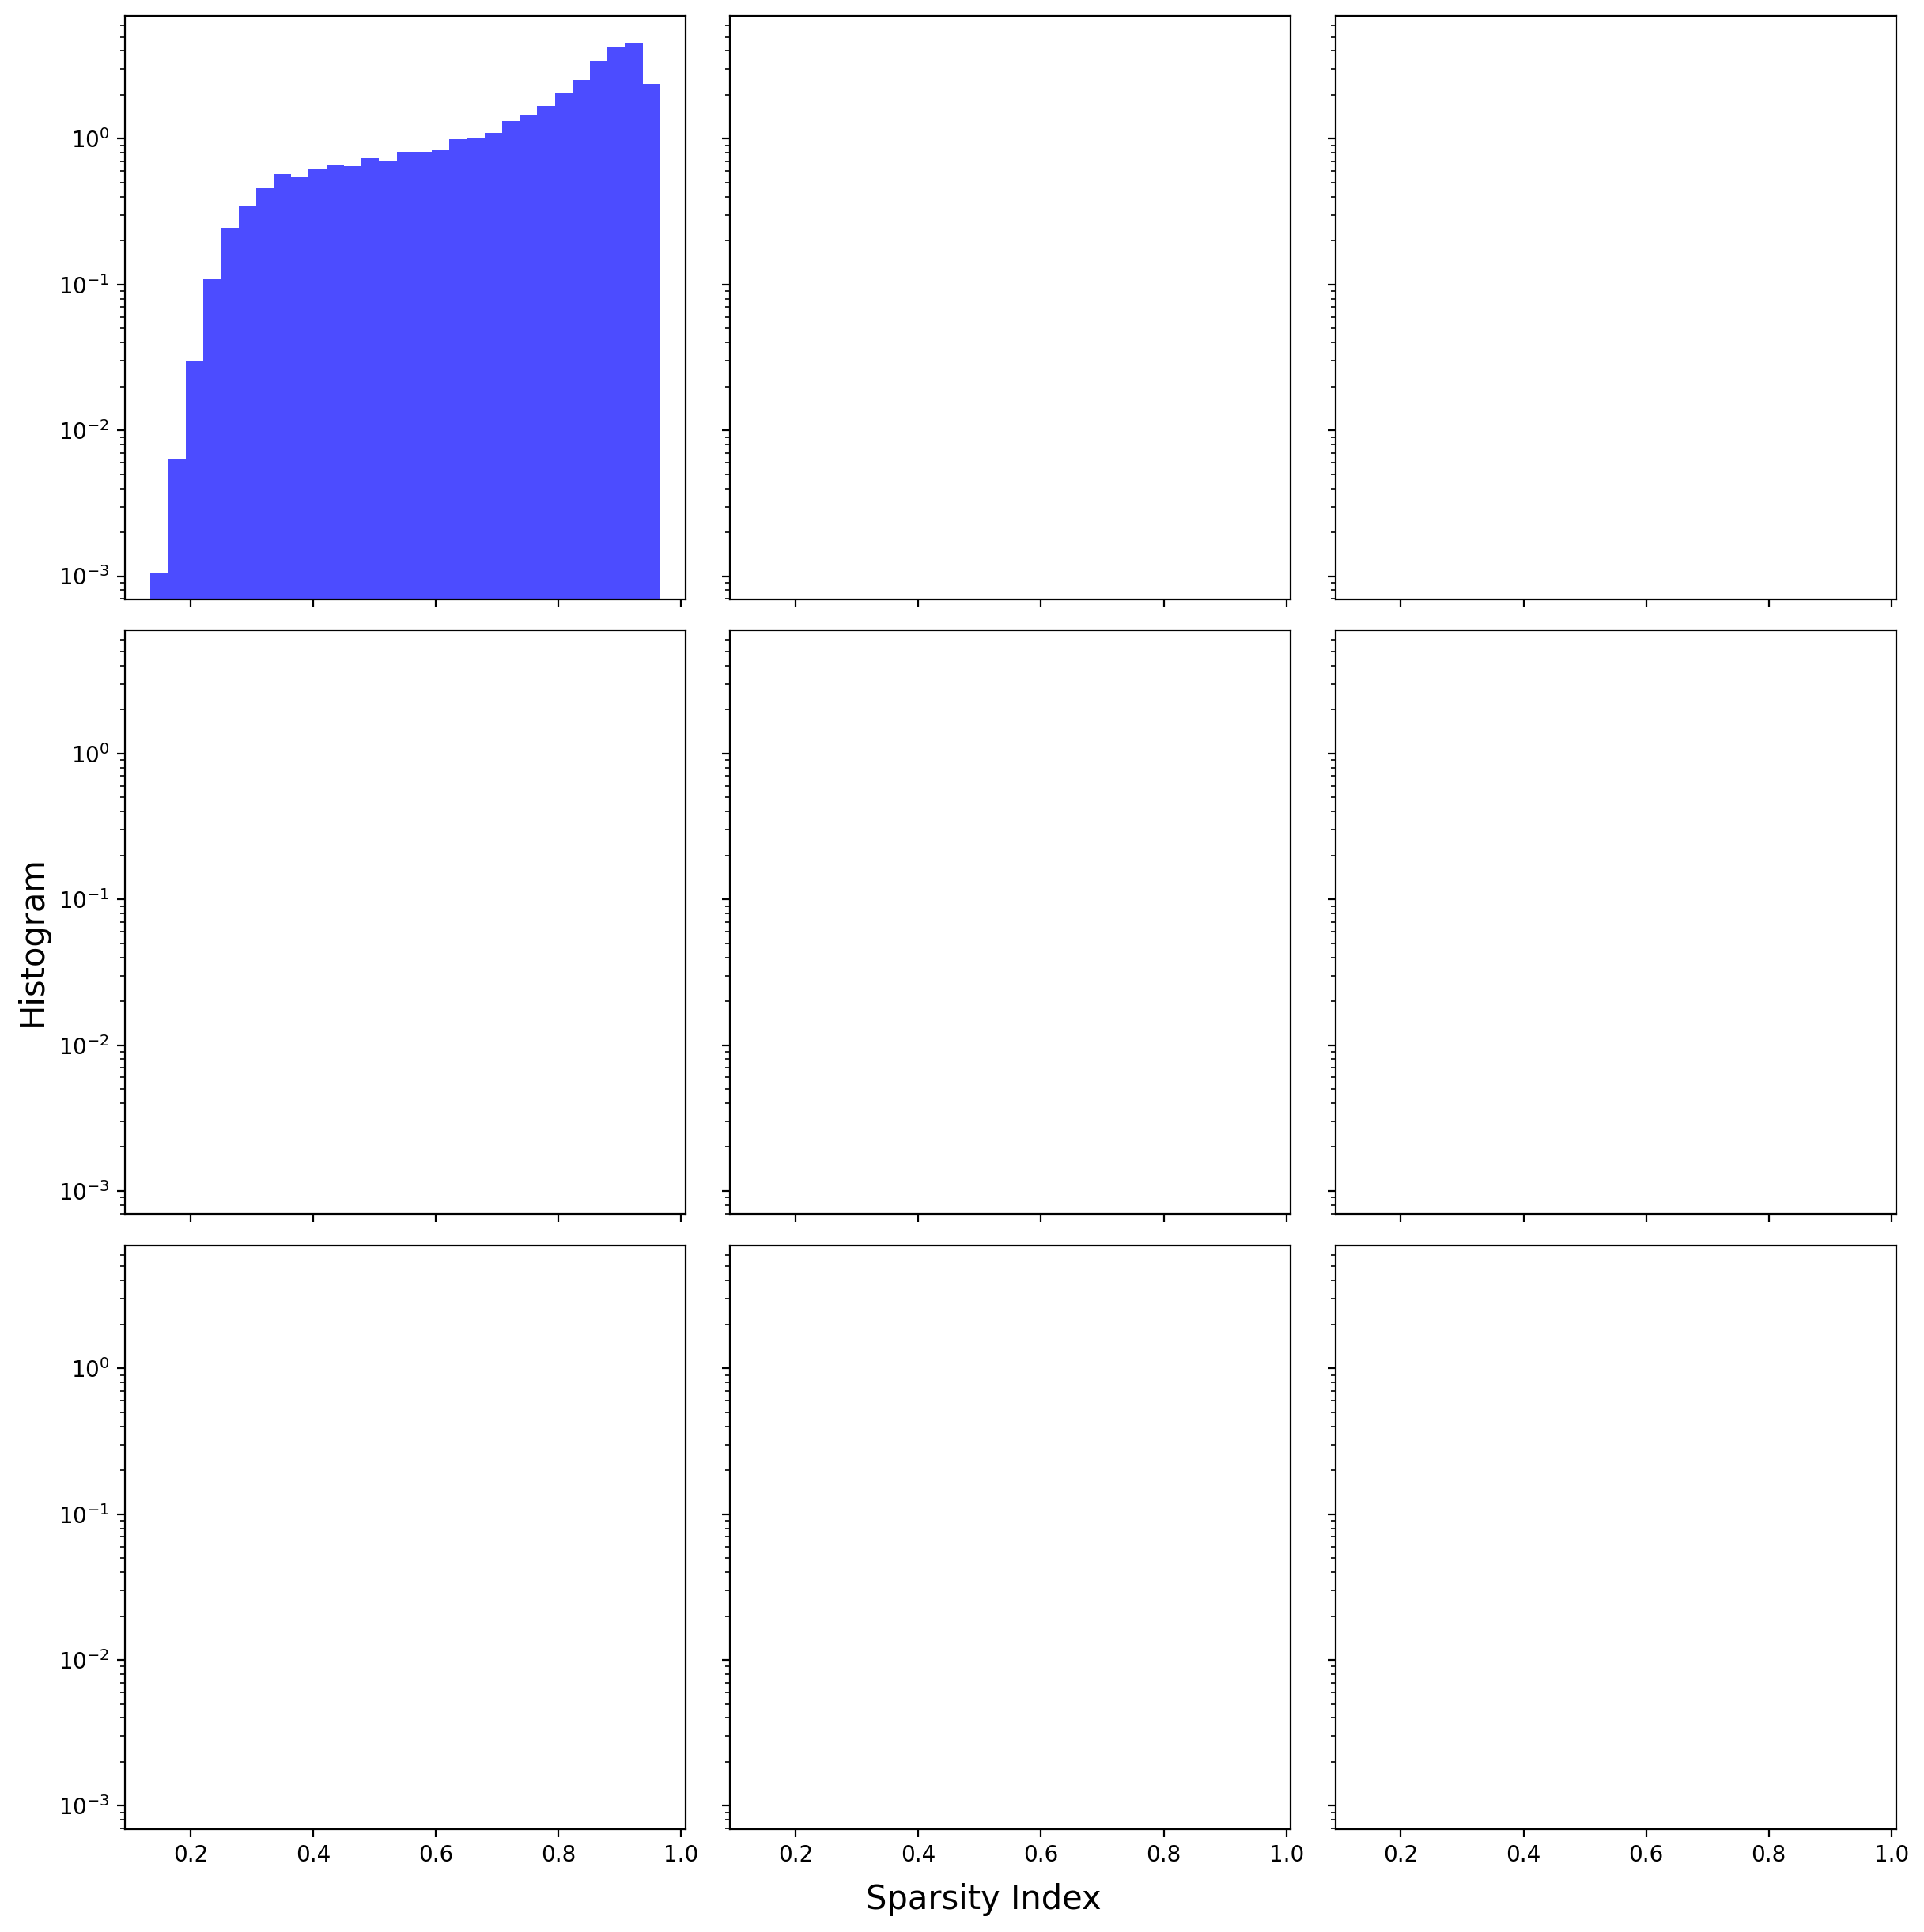

In [23]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]

# Energy Ranges
E_right = 50000000000
E_left = 100000
tmp = (entarget_samples < E_right) * (entarget_samples > E_left)
idxEnFilter = (tmp == True).nonzero(as_tuple=True)[0]

# Create lists for the histogram values
target_counts, recon_counts, sample_counts = [0] * (len(HLF_1_electron.relevantLayers) - 1), [0] * (len(HLF_1_electron.relevantLayers) - 1), [0] * (len(HLF_1_electron.relevantLayers) - 1)
target_bins, recon_bins, sample_bins = [0] * (len(HLF_1_electron.relevantLayers) - 1), [0] * (len(HLF_1_electron.relevantLayers) - 1), [0] * (len(HLF_1_electron.relevantLayers) - 1)

plt.figure(figsize=(8,6))
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=True, tight_layout=True)
fig.text(0.5, -0.01, 'Sparsity Index', ha='center', fontsize=15)
fig.text(-0.01, 0.5, 'Histogram', va='center', rotation='vertical', fontsize=15)

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    minVal, maxVal = min(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy()), max(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy())
    binwidth = (maxVal-minVal)/30
    
    # Store the values of the histogram with the same normalization and bin sizes
    target_counts[i], target_bins[i] = np.histogram(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth))
    recon_counts[i], recon_bins[i] = np.histogram(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth))
    sample_counts[i], sample_bins[i] = np.histogram(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth))
    ax.hist((((xtarget_samples[idxEnFilter])[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(),  bins=np.arange(minVal, maxVal, binwidth), log=True, density=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7)
    ax.hist((((xrecon_samples[idxEnFilter])[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal, binwidth), log=True, density=True, histtype='step', linewidth=2.5, color="c")
    ax.hist((((xgen_samples[idxEnFilter])[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal, binwidth), log=True, density=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot")
    ax.hist((((xgen_samples_1429[idxEnFilter])[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal, binwidth), log=True, density=True, histtype='step', linewidth=2.5, color="purple", linestyle="dashdot")
    # ax.hist(((xgen_samples_qpu[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=30, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashed")
    if i == 0:
        ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], fontsize=14, loc = 'upper left')
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}', fontsize=12)

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig(f'/home/luian1/CaloQVAE/figs/{modelname}/sparsity_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [ ]:
def KL_div(target, inp):
    KL_met = 0
    for i in range(min(len(inp), len(target))):
        if target[i] == 0:
            KL_met += 0
        else:
            KL_met += target[i] * np.log(abs(target[i]/inp[i]))
    return KL_met / min(len(inp), len(target))

def JSD(P, Q):
    P = np.asarray(P, dtype=np.float)
    Q = np.asarray(Q, dtype=np.float)
    M = 0.5 * (P + Q)
    return 0.5 * (KL_div(P, M) + KL_div(Q, M))

def Hellinger_dist(target, inp):
    Hel_dist = 0
    for i in range(min(len(inp), len(target))):
        Hel_dist += ((target[i]) ** 0.5 - (inp[i]) ** 0.5) ** 2
    return (1 / (2 ** 0.5)) * ((Hel_dist) ** 0.5)

print(idxPrev, idx)
print(xtarget_samples.size()) # [# of data cylinders, # voxels per cylinder]
print((xtarget_samples[:, idxPrev:idx] == 0))
# l = idx = idxPrev
print((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1))
print(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), ((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy().shape)

plt.plot(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy())
plt.show()

print(target_counts[0], recon_counts[0])
print("KL div b/w target and recon: ", KL_div(target_counts[0], recon_counts[0]))
print("KL div b/w target and gen: ", KL_div(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), ((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy()))

In [ ]:
# Calculate a Jensen-Shannon Divergence (JSD) a smoothed version of KL divergence to handle / 0

layers = np.linspace(0, 44, 45)
JSD_recon = np.zeros(45)
JSD_gen1 = np.zeros(45)
JSD_gen2 = np.zeros(45)

HLD_recon = np.zeros(45)
HLD_gen1 = np.zeros(45)
HLD_gen2 = np.zeros(45)

# Create lists for the histogram values
target_counts, recon_counts, gen_counts, gen_counts_1429 = [0] * 44, [0] * 44, [0] * 44, [0] * 44
target_bins, recon_bins, gen_bins, gen_bins_1429 = [0] * 44, [0] * 44, [0] * 44, [0] * 44

for i in range(44): # of layers in the cylinder - 1
    idx = (i+1)*9*16
    idxPrev = (i)*9*16
    l = idx - idxPrev
    minVal, maxVal = min(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy()), max(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy())
    binwidth = (maxVal-minVal)/30
    target_counts[i], target_bins[i] = np.histogram(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), density=True)
    recon_counts[i], recon_bins[i] = np.histogram(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), density=True)
    gen_counts[i], gen_bins[i] = np.histogram(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), density=True)
    gen_counts_1429[i], gen_bins_1429[i] = np.histogram(((xgen_samples_1429[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), density=True)

#     gen_counts[i], gen_bins[i] = np.histogram(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), weights = np.ones_like((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l) * 0.1)
    mid_recon = 0.5 * (target_counts[i] + recon_counts[i])
    mid_gen1 = 0.5 * (target_counts[i] + gen_counts[i])
    mid_gen2 = 0.5 * (target_counts[i] + gen_counts_1429[i])
    
#     print(mid_recon, target_counts[0].tolist())
    
#     print("testing: ", KL_div(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), mid_recon))
#     print((0.5 * (KL_div(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), mid_recon) + KL_div(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), mid_recon))))
   
    JSD_recon[i] = (0.5 * (KL_div(target_counts[i].tolist(), mid_recon) + KL_div(recon_counts[i].tolist(), mid_recon)))
    JSD_gen1[i] = (0.5 * (KL_div(target_counts[i].tolist(), mid_gen1) + KL_div(gen_counts[i].tolist(), mid_gen1)))
    JSD_gen2[i] = (0.5 * (KL_div(target_counts[i].tolist(), mid_gen2) + KL_div(gen_counts_1429[i].tolist(), mid_gen2)))
    
    HLD_recon[i] = Hellinger_dist(target_counts[i].tolist(), recon_counts[i].tolist())
    HLD_gen1[i] = Hellinger_dist(target_counts[i].tolist(), gen_counts[i].tolist())
    HLD_gen2[i] = Hellinger_dist(target_counts[i].tolist(), gen_counts_1429[i].tolist())

print("Layer Size: ", layers.size)
print("JSD Size: ", len(JSD_recon))
plt.scatter(layers[:-1], np.asarray(JSD_recon[:-1]))
plt.scatter(layers[:-1], np.asarray(JSD_gen1[:-1]))
plt.scatter(layers[:-1], np.asarray(JSD_gen2[:-1]))

plt.xlabel("Layer Number")
plt.ylabel("JSD Divergence Value")
plt.legend(["Target vs Recon", "Target vs Sample 1372", "Target vs Sample 454"])
plt.title("JSD Divergence Comparison per Layer")
plt.grid("True")
plt.show()

In [ ]:
plt.scatter(layers[:-1], np.asarray(HLD_recon[:-1]))
plt.scatter(layers[:-1], np.asarray(HLD_gen1[:-1]))
plt.scatter(layers[:-1], np.asarray(HLD_gen2[:-1]))


plt.xlabel("Layer Number")
plt.ylabel("Hellinger Distance")
plt.legend(["Target vs Recon", "Target vs Sample 1372", "Target vs Sample 454"])
plt.title("Hellinger Distance Comparison per Layer")
plt.grid("True")
plt.show()

In [ ]:
print(entarget_samples)
entarget_samplesnp = entarget_samples.numpy()
ind = np.argsort(entarget_samplesnp, axis = 0).flatten()
print(ind)
print(entarget_samples[ind])
sortxtarget_samples = xtarget_samples[ind]
print(sortxtarget_samples, sortxtarget_samples.shape)
print(max(sortxtarget_samples[0]))

In [ ]:
# test = np.logspace(0, np.log(1000000), 44, base=10)
# print(test)

# idxPrev = test[0]
# print(entarget_samples, entarget_samples.shape)
# for i in range(44):
#     print(len(entarget_samples[:, int(test[i]): int(test[i+1])]))

x=np.zeros([4,4])
x[0][0] = 1
print(x)

samps = np.linspace(0, 44, 12)
print(samps)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
samps = np.linspace(0, len(entarget_samples) - 1, 10)

layers = np.linspace(0, 44, 45)
# JSD_recon = np.zeros([44,44])
JSD_gen = np.zeros([44,44])

# HLD_recon = np.zeros([44,44])
HLD_gen = np.zeros([44,44])

# Sort samples
entarget_samplesnp = entarget_samples.numpy()
ind = np.argsort(entarget_samplesnp, axis=0).flatten()
sortentarget_samples = entarget_samples[ind]
sortxtarget_samples = xtarget_samples[ind]
# sortxrecon_samples = xrecon_samples[ind]
sortxgen_samples = xgen_samples_1429[ind]
inc_energies = np.linspace(0, len(entarget_samples), 46).astype(int)

xenergies = (((sortentarget_samples[samps] / 1).flatten()).numpy().astype(int)).tolist()

minVal, maxVal = 0, 1
binwidth = (maxVal-minVal)/20

for j in range(44):
    
    # Create lists for the histogram values
    target_counts, gen_counts = [0] * 44, [0] * 44
    target_bins, gen_bins = [0] * 44, [0] * 44

    sub_target_samples = sortxtarget_samples[inc_energies[j] : inc_energies[j+1]]
    # sub_recon_samples = sortxrecon_samples[inc_energies[j] : inc_energies[j+1]]
    sub_gen_samples = sortxgen_samples[inc_energies[j] : inc_energies[j+1]]

    for i in range(44): # of layers in the cylinder - 1

        idx = (i+1)*9*16
        idxPrev = (i)*9*16
        l = idx - idxPrev
        
        target_counts[i], target_bins[i] = np.histogram(((sub_target_samples[:, idxPrev:idx] == 0).sum(axis=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth),density=True)
        # recon_counts[i], recon_bins[i] = np.histogram(((sub_recon_samples[:, idxPrev:idx] == 0).sum(axis=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), density=True)
        gen_counts[i], gen_bins[i] = np.histogram(((sub_gen_samples[:, idxPrev:idx] == 0).sum(axis=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), density=True)
        # mid_recon = 0.5 * (target_counts[i] + recon_counts[i])
        mid_gen = 0.5 * (target_counts[i] + gen_counts[i])

        # JSD_recon[j][i] = (0.5 * (KL_div(target_counts[i].tolist(), mid_recon) + KL_div(recon_counts[i].tolist(), mid_recon)))
        JSD_gen[j][i] = (0.5 * (KL_div(target_counts[i].tolist(), mid_gen) + KL_div(gen_counts[i].tolist(), mid_gen)))

        # HLD_recon[j][i] = Hellinger_dist(target_counts[i].tolist(), recon_counts[i].tolist())
        HLD_gen[j][i] = Hellinger_dist(target_counts[i].tolist(), gen_counts[i].tolist())

        if i == 0: 
            print(target_counts, len(target_counts))
            print(gen_counts)

# print(JSD_recon)
# print(min(JSD_recon.flatten()))
# print(JSD_recon, JSD_recon.shape)

# Plotting for JSD_gen
fig, ax = plt.subplots(figsize=(12, 6))

cax = ax.imshow(JSD_gen, interpolation='nearest', cmap='viridis')
ax.set_aspect('equal')
ax.set_title("Target vs Sample")
ax.set_yticks(np.linspace(0, 43, 10))
ax.set_yticklabels([int(x) for x in xenergies])
ax.set_ylabel("Incident Energy Ranges")
ax.set_xlabel("Layer Number")

divider = make_axes_locatable(ax)
cax_cbar = divider.append_axes("right", size="5%", pad=0.25)
cbar = fig.colorbar(cax, cax=cax_cbar)
cbar.set_label('JSD Divergence Value')

plt.tight_layout()
plt.show()

In [ ]:
# Plotting for HLD_recon and HLD_gen
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig, ax2 = plt.subplots(figsize=(12, 6))

# Plot for HLD_recon
# cax1 = ax1.imshow(HLD_recon, interpolation='nearest', cmap='viridis')
# ax1.set_aspect('equal')
# ax1.set_yticks(np.linspace(0, 43, 10))
# ax1.set_yticklabels([int(x) for x in xenergies])
# ax1.set_ylabel("Incident Energy Ranges")
# ax1.set_xlabel("Layer Number")
# divider1 = make_axes_locatable(ax1)
# cax_cbar1 = divider1.append_axes("right", size="5%", pad=0.25)
# cbar1 = fig.colorbar(cax1, cax=cax_cbar1)
# cbar1.set_label('Hellinger Distance Value')

# Plot for HLD_gen
cax2 = ax2.imshow(HLD_gen, interpolation='nearest', cmap='viridis')
ax2.set_aspect('equal')
ax2.set_yticks(np.linspace(0, 43, 10))
ax2.set_yticklabels([int(x) for x in xenergies])
ax2.set_ylabel("Incident Energy Ranges")
ax2.set_xlabel("Layer Number")
divider2 = make_axes_locatable(ax2)
cax_cbar2 = divider2.append_axes("right", size="5%", pad=0.25)
cbar2 = fig.colorbar(cax2, cax=cax_cbar2)
cbar2.set_label('Hellinger Distance Value')

plt.tight_layout()
plt.show()


In [ ]:
plt.scatter(entarget_samples, ((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy())
plt.scatter(entarget_samples, ((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy())

plt.xlabel("Incidence Energy (GeV)")
plt.ylabel("Sparsity")
plt.legend(["GT", "Recon", "Samples", "Sample /w QPU"])
plt.title(f'{ds[part]}')
plt.grid("True")
plt.show()

In [ ]:
fig, axes = plt.subplots(3,2, figsize=(8,8), tight_layout=True)
fig.text(0.5, 0.0, 'GT energy per event (GeV)', ha='center')
fig.text(0.5, 1.0, f'{ds[part]}', ha='center', fontsize=12)

axes[0,0].scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="b")
axes[0,0].plot([0,800],[0,800], c='red', lw=2.5, label='y=x')
axes[0,0].set_ylabel("Recon energy per event (GeV)")
axes[0,0].legend()
axes[0,0].grid("True")
axes[0,0].set_yscale('log')
axes[0,0].set_xscale('log')

axes[0,1].scatter(xtarget_samples.sum(dim=1).numpy()/1000, (xtarget_samples.sum(dim=1).numpy() - xrecon_samples.sum(dim=1).numpy())/1000, marker='.', alpha=.5, color="b")
axes[0,1].set_ylabel("Abs error (GeV)")
axes[0,1].set_ylim([-40,40])
# axes[0,1].legend()
# axes[0,1].set_yscale('log')
axes[0,1].grid("True")

axes[1,0].scatter(1/(entarget_samples.numpy()/1000), np.abs(entarget_samples.reshape(-1).numpy() - xtarget_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.5, color="blue", label="Simulation")
axes[1,0].scatter(1/(entarget_samples.numpy()/1000), np.abs(entarget_samples.reshape(-1).numpy() - xrecon_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.05, color="red", label="Model")
axes[1,0].plot([1e-3,1e0],np.power([1e-3,1e0],0.25)*np.power(10,2.0), c='orange', lw=2.5, label='slope=0.25', linestyle="dashdot")
axes[1,0].grid("True")
axes[1,0].set_yscale('log')
axes[1,0].set_xscale('log')
axes[1,0].legend()
axes[1,0].set_ylabel("Relative Error")

axes[1,1].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy()/1000 - xtarget_samples.sum(dim=1).numpy()/1000), marker='.', alpha=1, color="blue", label="Simulation")
axes[1,1].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy()/1000 - xrecon_samples.sum(dim=1).numpy()/1000), marker='.', alpha=.2, color="red", label="Model")
axes[1,1].plot([1,800],np.sqrt([1,800]), c='orange', lw=2.5, label='y=sqrt(x)', linestyle="dashdot")
axes[1,1].plot([1,800],[1,800], c='c', lw=2.5, label='y=x', linestyle="dashed")
axes[1,1].grid("True")
axes[1,1].set_yscale('log')
axes[1,1].set_xscale('log')
axes[1,1].set_ylabel("Absolute Error")
axes[1,1].legend()


# Merge the first row's axes
gs = axes[2, 0].get_gridspec()
for ax in axes[2, :]:
    ax.remove()
ax_big = fig.add_subplot(gs[2, :])
ax_big.scatter(1/(xtarget_samples.sum(dim=1).numpy()/1000), np.abs(xtarget_samples.sum(dim=1).numpy() - xrecon_samples.sum(dim=1).numpy())/(xtarget_samples.sum(dim=1).numpy()+1e-3), marker='.', alpha=.5, color="blue")
ax_big.plot([1e-3,1e1],np.sqrt([1e-3,1e1])*np.power(1,3.5), c='orange', lw=2.5, label='y=sqrt(x)', linestyle="dashdot")
ax_big.grid("True")
ax_big.set_yscale('log')
ax_big.set_xscale('log')
ax_big.legend()
ax_big.set_ylim([1e-5,1e1])
ax_big.set_yticks([1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1])
ax_big.set_ylabel("Relative Recon Error")
plt.show()

In [ ]:
#Energy

In [ ]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]

# Create lists for the histogram values
target_counts, recon_counts, sample_counts = [0] * (len(HLF_1_electron.relevantLayers) - 1), [0] * (len(HLF_1_electron.relevantLayers) - 1), [0] * (len(HLF_1_electron.relevantLayers) - 1)
target_bins, recon_bins, sample_bins = [0] * (len(HLF_1_electron.relevantLayers) - 1), [0] * (len(HLF_1_electron.relevantLayers) - 1), [0] * (len(HLF_1_electron.relevantLayers) - 1)

plt.figure(figsize=(8,6))
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=False, tight_layout=True)
fig.text(0.5, 0.0, 'Energy per event (GeV)', ha='center', fontsize=15)
fig.text(0.0, 0.5, 'Histogram', va='center', rotation='vertical', fontsize=15)

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    
    # Store the values of the histogram with the same normalization and bin sizes
    target_counts[i], target_bins[i] = np.histogram(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20)
    recon_counts[i], recon_bins[i] = np.histogram(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20)
    sample_counts[i], sample_bins[i] = np.histogram(xgen_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20)
    
    ax.hist(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000,  bins=20, log=True, density=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7)
    ax.hist(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, density=True, histtype='step', linewidth=2.5, color="c")
    ax.hist(xgen_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, density=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot")
    ax.hist(xgen_samples_1429[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, density=True, histtype='step', linewidth=2.5, color="purple", linestyle="dashdot")

    if i == 0:
        ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], fontsize=15)
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}')

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig(f'/home/luian1/CaloQVAE/figs/{modelname}/sparsity_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()


In [ ]:
print(xtarget_samples.shape)

E_right = 12000 # MeV
E_left = 10000 # MeV
tmp = (entarget_samples < E_right) * (entarget_samples > E_left)
idxEnFilter = (tmp == True).nonzero(as_tuple=True)[0]
print(idxEnFilter.shape)
print(xtarget_samples, xtarget_samples.shape)
# print(entarget_samples[idxEnFilter])
print(xtarget_samples[idxEnFilter], xtarget_samples[idxEnFilter].shape)
len(idxEnFilter)

In [ ]:
xtarget_samples = data_showers
print(xtarget_samples, xtarget_samples.shape)
print(xgen_samples_1429, xgen_samples_1429.shape)
print(entarget_samples, entarget_samples.shape)

In [ ]:
print(xrecon_samples, xrecon_samples.shape)

In [ ]:
# Calculate a Jensen-Shannon Divergence (JSD) a smoothed version of KL divergence to handle / 0

layers = np.linspace(0, 44, 45)
JSD_recon = np.zeros(45)
JSD_gen1 = np.zeros(45)
JSD_gen2 = np.zeros(45)

HLD_recon = np.zeros(45)
HLD_gen1 = np.zeros(45)
HLD_gen2 = np.zeros(45)

# Create lists for the histogram values
target_counts, recon_counts, gen_counts, gen_counts_1429 = [0] * 44, [0] * 44, [0] * 44, [0] * 44
target_bins, recon_bins, gen_bins, gen_bins_1429 = [0] * 44, [0] * 44, [0] * 44, [0] * 44

# Energy Ranges
E_right = 5000000000
E_left = 0
tmp = (entarget_samples < E_right) * (entarget_samples > E_left)
idxEnFilter = (tmp == True).nonzero(as_tuple=True)[0]

# Energy filtered samples
print(xtarget_samples)
print(xtarget_samples.shape, idxEnFilter.shape)
# xtarget_samples, xrecon_samples, gen_samples = xtarget_samples[idxEnFilter], xrecon_samples[idxEnFilter], xgen_samples[idxEnFilter] # this line creates problems when running it again 

for i in range(44): # of layers in the cylinder - 1
    idx = (i+1)*9*16
    idxPrev = (i)*9*16
    l = idx - idxPrev
    
    # target_counts[i], target_bins[i] = np.histogram((xtarget_samples[idxEnFilter])[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, density=True)
    # recon_counts[i], recon_bins[i] = np.histogram((xrecon_samples[idxEnFilter < xrecon_samples.shape[0]])[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20,density=True)
    # gen_counts[i], gen_bins[i] = np.histogram((xgen_samples[idxEnFilter])[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, density=True)
    # gen_counts_1429[i], gen_bins_1429[i] = np.histogram((xgen_samples[idxEnFilter])[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, density=True)

    target_counts[i], target_bins[i] = np.histogram(((xtarget_samples)[:, idxPrev:idx]).sum(dim=1).numpy()/1000, bins=20, density=True)
    recon_counts[i], recon_bins[i] = np.histogram(((xrecon_samples)[:, idxPrev:idx]).sum(dim=1).numpy()/1000, bins=20,density=True)
    gen_counts[i], gen_bins[i] = np.histogram(((xgen_samples)[:, idxPrev:idx]).sum(dim=1).numpy()/1000, bins=20, density=True)
    gen_counts_1429[i], gen_bins_1429[i] = np.histogram(((xgen_samples_1429)[:, idxPrev:idx]).sum(dim=1).numpy()/1000, bins=20, density=True)
    
    mid_recon = 0.5 * (target_counts[i] + recon_counts[i])
    mid_gen1 = 0.5 * (target_counts[i] + gen_counts[i])
    mid_gen2 = 0.5 * (target_counts[i] + gen_counts_1429[i])
    
#     print(mid_recon, target_counts[0].tolist())
    
#     print("testing: ", KL_div(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), mid_recon))
#     print((0.5 * (KL_div(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), mid_recon) + KL_div(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), mid_recon))))
   
    JSD_recon[i] = (0.5 * (KL_div(target_counts[i].tolist(), mid_recon) + KL_div(recon_counts[i].tolist(), mid_recon)))
    JSD_gen1[i] = (0.5 * (KL_div(target_counts[i].tolist(), mid_gen1) + KL_div(gen_counts[i].tolist(), mid_gen1)))
    JSD_gen2[i] = (0.5 * (KL_div(target_counts[i].tolist(), mid_gen2) + KL_div(gen_counts_1429[i].tolist(), mid_gen2)))
    
    HLD_recon[i] = Hellinger_dist(target_counts[i].tolist(), recon_counts[i].tolist())
    HLD_gen1[i] = Hellinger_dist(target_counts[i].tolist(), gen_counts[i].tolist())
    HLD_gen2[i] = Hellinger_dist(target_counts[i].tolist(), gen_counts_1429[i].tolist())

print("Layer Size: ", layers.size)
print("JSD Size: ", len(JSD_recon))
plt.scatter(layers[:-1], np.asarray(JSD_recon[:-1]))
plt.scatter(layers[:-1], np.asarray(JSD_gen1[:-1]))
plt.scatter(layers[:-1], np.asarray(JSD_gen2[:-1]))

plt.yscale('log')

plt.xlabel("Layer Number")
plt.ylabel("JSD Divergence Value")
plt.legend(["Target vs Recon", "Target vs Sample 1372", "Target vs Sample 454"])
plt.title("JSD Divergence Comparison per Layer")
plt.grid("True")
plt.show()

In [ ]:
plt.scatter(layers[:-1], np.asarray(HLD_recon[:-1]))
plt.scatter(layers[:-1], np.asarray(HLD_gen1[:-1]))
plt.scatter(layers[:-1], np.asarray(HLD_gen2[:-1]))

plt.xlabel("Layer Number")
plt.ylabel("Hellinger Distance")
plt.legend(["Target vs Recon", "Target vs Sample 1372", "Target vs Sample 454"])
plt.title("Hellinger Distance Comparison per Layer")
plt.grid("True")
plt.show()

In [ ]:
# Calculate a Jensen-Shannon Divergence (JSD) a smoothed version of KL divergence to handle / 0
from mpl_toolkits.axes_grid1 import make_axes_locatable

samps = np.linspace(0, len(entarget_samples_orig) - 1, 10)
print(entarget_samples_orig, entarget_samples_orig.shape)

layers = np.linspace(0, 44, 45)
JSD_recon = np.zeros([44,44])
JSD_gen = np.zeros([44,44])

HLD_recon = np.zeros([44,44])
HLD_gen = np.zeros([44,44])

# Sort samples
entarget_samplesnp = entarget_samples_orig.numpy()
ind = np.argsort(entarget_samplesnp, axis = 0).flatten()
sortentarget_samples = entarget_samples_orig[ind]
sortxtarget_samples = xtarget_samples_orig[ind]
sortxrecon_samples = xrecon_samples[ind]
sortxgen_samples = xgen_samples[ind]
inc_energies = np.linspace(0, len(entarget_samples_orig), 46).astype(int)

xenergies = (((sortentarget_samples[samps] / 1).flatten()).numpy().astype(int)).tolist()

for j in range(44):
    
    # Create lists for the histogram values
    target_counts, recon_counts, gen_counts = [0] * 44, [0] * 44, [0] * 44
    target_bins, recon_bins, gen_bins = [0] * 44, [0] * 44, [0] * 44

    
    sub_target_samples = sortxtarget_samples[inc_energies[j] : inc_energies[j+1]]
    sub_recon_samples = sortxrecon_samples[inc_energies[j] : inc_energies[j+1]]
    sub_gen_samples = sortxgen_samples[inc_energies[j] : inc_energies[j+1]]
    for i in range(44): # of layers in the cylinder - 1
#         print(sub_target_samples, sub_target_samples.shape)
        idx = (i+1)*9*16
        idxPrev = (i)*9*16
        l = idx - idxPrev
#         target_counts[i], target_bins[i] = np.histogram(((sub_target_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth))
#         recon_counts[i], recon_bins[i] = np.histogram(((sub_recon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth))
#         gen_counts[i], gen_bins[i] = np.histogram(((sub_gen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth))
        
        target_counts[i], target_bins[i] = np.histogram((sub_target_samples[:, idxPrev:idx]).sum(dim=1).numpy()/1000, bins=20)
        recon_counts[i], recon_bins[i] = np.histogram((sub_recon_samples[:, idxPrev:idx]).sum(dim=1).numpy()/1000, bins=20)
        gen_counts[i], gen_bins[i] = np.histogram((sub_gen_samples[:, idxPrev:idx]).sum(dim=1).numpy()/1000, bins=20)

        
        mid_recon = 0.5 * (target_counts[i] + recon_counts[i])
        mid_gen = 0.5 * (target_counts[i] + gen_counts[i])

    #     print(mid_recon, target_counts[0].tolist())

    #     print("testing: ", KL_div(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), mid_recon))
    #     print((0.5 * (KL_div(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), mid_recon) + KL_div(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), mid_recon))))

        JSD_recon[j][i] = (0.5 * (KL_div(target_counts[i].tolist(), mid_recon) + KL_div(recon_counts[i].tolist(), mid_recon)))
        JSD_gen[j][i] = (0.5 * (KL_div(target_counts[i].tolist(), mid_gen) + KL_div(gen_counts[i].tolist(), mid_gen)))

        HLD_recon[j][i] = Hellinger_dist(target_counts[i].tolist(), recon_counts[i].tolist())
        HLD_gen[j][i] = Hellinger_dist(target_counts[i].tolist(), gen_counts[i].tolist())

    if j == 43:
        print(target_counts, len(target_counts))
        
# print(JSD_recon)
# print(min(JSD_recon.flatten()))
print(JSD_recon, JSD_recon.shape)

# Plotting for JSD_recon and JSD_gen
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for JSD_recon
cax1 = ax1.imshow(JSD_recon, interpolation='nearest', cmap='viridis')
ax1.set_aspect('equal')
ax1.set_title('Target vs Recon')
ax1.set_yticks(np.linspace(0, 43, 10))
ax1.set_yticklabels([int(x) for x in xenergies])
ax1.set_ylabel("Incident Energy Ranges")
ax1.set_xlabel("Layer Number")
divider1 = make_axes_locatable(ax1)
cax_cbar1 = divider1.append_axes("right", size="5%", pad=0.25)
cbar1 = fig.colorbar(cax1, cax=cax_cbar1)
cbar1.set_label('JSD Divergence Value')

# Plot for JSD_gen
cax2 = ax2.imshow(JSD_gen, interpolation='nearest', cmap='viridis')
ax2.set_aspect('equal')
ax2.set_title('Target vs Sample')
ax2.set_yticks(np.linspace(0, 43, 10))
ax2.set_yticklabels([int(x) for x in xenergies])
ax2.set_ylabel("Incident Energy Ranges")
ax2.set_xlabel("Layer Number")
divider2 = make_axes_locatable(ax2)
cax_cbar2 = divider2.append_axes("right", size="5%", pad=0.25)
cbar2 = fig.colorbar(cax2, cax=cax_cbar2)
cbar2.set_label('JSD Divergence Value')

plt.tight_layout()
plt.show()

In [ ]:
print(entarget_samples, entarget_samples.shape)
print(xtarget_samples, xtarget_samples.shape)
print(xgen_samples_1429, xgen_samples_1429.shape)

In [ ]:
samps = np.linspace(0, len(entarget_samples) - 1, 10)

layers = np.linspace(0, 44, 45)
# JSD_recon = np.zeros([44,44])
JSD_gen = np.zeros([44,44])

# HLD_recon = np.zeros([44,44])
HLD_gen = np.zeros([44,44])

# Sort samples
entarget_samplesnp = entarget_samples.numpy()
ind = np.argsort(entarget_samplesnp, axis=0).flatten()
sortentarget_samples = entarget_samples[ind]
sortxtarget_samples = xtarget_samples[ind]
# sortxrecon_samples = xrecon_samples[ind]
sortxgen_samples = xgen_samples_1429[ind]
inc_energies = np.linspace(0, len(entarget_samples), 46).astype(int)

print(sortentarget_samples, sortentarget_samples.shape)
print(sortxtarget_samples, sortxtarget_samples.shape)
print(sortxgen_samples, sortxgen_samples.shape)

xenergies = (((sortentarget_samples[samps] / 1).flatten()).numpy().astype(int)).tolist()

minVal, maxVal = 0, 1
binwidth = (maxVal-minVal)/20

for j in range(44):
    
    # Create lists for the histogram values
    target_counts, gen_counts = [0] * 44, [0] * 44
    target_bins, gen_bins = [0] * 44, [0] * 44

    sub_target_samples = sortxtarget_samples[inc_energies[j] : inc_energies[j+1]]
    # sub_recon_samples = sortxrecon_samples[inc_energies[j] : inc_energies[j+1]]
    sub_gen_samples = sortxgen_samples[inc_energies[j] : inc_energies[j+1]]

    for i in range(44): # of layers in the cylinder - 1

        idx = (i+1)*9*16
        idxPrev = (i)*9*16
        l = idx - idxPrev
        
        target_counts[i], target_bins[i] = np.histogram((sub_target_samples[:, idxPrev:idx]).sum(dim=1).numpy()/1000, bins=20)
        # recon_counts[i], recon_bins[i] = np.histogram((sub_recon_samples[:, idxPrev:idx]).sum(dim=1).numpy()/1000, bins=20)
        gen_counts[i], gen_bins[i] = np.histogram((sub_gen_samples[:, idxPrev:idx]).sum(dim=1).numpy()/1000, bins=20)
        # mid_recon = 0.5 * (target_counts[i] + recon_counts[i])
        mid_gen = 0.5 * (target_counts[i] + gen_counts[i])

        # JSD_recon[j][i] = (0.5 * (KL_div(target_counts[i].tolist(), mid_recon) + KL_div(recon_counts[i].tolist(), mid_recon)))
        JSD_gen[j][i] = (0.5 * (KL_div(target_counts[i].tolist(), mid_gen) + KL_div(gen_counts[i].tolist(), mid_gen)))

        # HLD_recon[j][i] = Hellinger_dist(target_counts[i].tolist(), recon_counts[i].tolist())
        HLD_gen[j][i] = Hellinger_dist(target_counts[i].tolist(), gen_counts[i].tolist())

print(JSD_recon)
print(min(JSD_recon.flatten()))
print(JSD_recon, JSD_recon.shape)

# Plotting for JSD_gen
fig, ax = plt.subplots(figsize=(12, 6))

cax = ax.imshow(JSD_gen, interpolation='nearest', cmap='viridis')
ax.set_aspect('equal')
ax.set_title("Target vs Sample")
ax.set_yticks(np.linspace(0, 43, 10))
ax.set_yticklabels([int(x) for x in xenergies])
ax.set_ylabel("Incident Energy Ranges")
ax.set_xlabel("Layer Number")

divider = make_axes_locatable(ax)
cax_cbar = divider.append_axes("right", size="5%", pad=0.25)
cbar = fig.colorbar(cax, cax=cax_cbar)
cbar.set_label('JSD Divergence Value')

plt.tight_layout()
plt.show()

In [ ]:
# Plotting for HLD_recon and HLD_gen
fig, ax2 = plt.subplots(figsize=(12, 6))

# Plot for HLD_recon
# cax1 = ax1.imshow(HLD_recon, interpolation='nearest', cmap='viridis')
# ax1.set_aspect('equal')
# ax1.set_yticks(np.linspace(0, 43, 10))
# ax1.set_yticklabels([int(x) for x in xenergies])
# ax1.set_ylabel("Incident Energy Ranges")
# ax1.set_xlabel("Layer Number")
# divider1 = make_axes_locatable(ax1)
# cax_cbar1 = divider1.append_axes("right", size="5%", pad=0.25)
# cbar1 = fig.colorbar(cax1, cax=cax_cbar1)
# cbar1.set_label('Hellinger Distance Value')

# Plot for HLD_gen
cax2 = ax2.imshow(HLD_gen, interpolation='nearest', cmap='viridis')
ax2.set_aspect('equal')
ax2.set_yticks(np.linspace(0, 43, 10))
ax2.set_yticklabels([int(x) for x in xenergies])
ax2.set_ylabel("Incident Energy Ranges")
ax2.set_xlabel("Layer Number")
divider2 = make_axes_locatable(ax2)
cax_cbar2 = divider2.append_axes("right", size="5%", pad=0.25)
cbar2 = fig.colorbar(cax2, cax=cax_cbar2)
cbar2.set_label('Hellinger Distance Value')

plt.tight_layout()
plt.show()


In [ ]:
plt.hist((xtarget_samples[idxEnFilter,:].sum(dim=1)/entarget_samples[idxEnFilter].view(-1)).numpy(), bins=30, log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7, density=True)
plt.hist((xrecon_samples[idxEnFilter,:].sum(dim=1).numpy()/entarget_samples[idxEnFilter].view(-1)).numpy(), bins=30, log=True, histtype='step', linewidth=2.5, color="c", density=True)
plt.hist((xgen_samples[idxEnFilter,:].sum(dim=1).numpy()/entarget_samples[idxEnFilter].view(-1)).numpy(), bins=30, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot", density=True)

plt.xlabel("Energy ratio", fontsize=15)
# plt.xscale('log')

plt.ylabel("Histogram", fontsize=15)
plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"])
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_ration_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

# Energy across all voxels throughout the cylinder / incidence energy

In [ ]:
import jetnet
# Refer to Documentation: https://jetnet.readthedocs.io/en/latest/pages/metrics.html#jetnet.evaluation.fpd
# Metrics will be implemented once dataset # and sample # matches
# jetnet.evaluation.fpd(real_features: Tensor | np.ndarray, gen_features: Tensor | np.ndarray, min_samples: int = 20000, max_samples: int = 50000, num_batches: int = 20, num_points: int = 10, normalise: bool = True, seed: int = 42)→ tuple[float, float]
# jetnet.evaluation.kpd(real_features: Tensor | np.ndarray, gen_features: Tensor | np.ndarray, num_batches: int = 10, batch_size: int = 5000, normalise: bool = True, seed: int = 42, num_threads: int | None = None)→ tuple[float, float]

In [ ]:
# plt.hist((xtarget_samples_orig.sum(dim=1)/entarget_samples_orig[idxEnFilter].view(-1)).numpy(), bins=30, log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7, density=True)
# plt.hist((xrecon_samples.sum(dim=1).numpy()/entarget_samples_orig[idxEnFilter].view(-1)).numpy(), bins=30, log=True, histtype='step', linewidth=2.5, color="c", density=True)
# plt.hist((xgen_samples.sum(dim=1).numpy()/entarget_samples_orig[idxEnFilter].view(-1)).numpy(), bins=30, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot", density=True)

plt.hist((xtarget_samples_orig.sum(dim=1)/entarget_samples_orig.view(-1)).numpy(), bins=30, log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7, density=True)
plt.hist((xrecon_samples.sum(dim=1).numpy()/entarget_samples_orig.view(-1)).numpy(), bins=30, log=True, histtype='step', linewidth=2.5, color="c", density=True)
plt.hist((xgen_samples.sum(dim=1).numpy()/entarget_samples_orig.view(-1)).numpy(), bins=30, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot", density=True)

plt.xlabel("Energy ratio", fontsize=15)
# plt.xscale('log')

plt.ylabel("Histogram", fontsize=15)
plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"])
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_ration_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

# Energy across all voxels throughout the cylinder / incidence energy

In [ ]:
print(entarget_samples_orig, entarget_samples_orig.shape, entarget_samples_orig.view(-1), entarget_samples_orig.view(-1).shape)

In [ ]:
from scipy.stats import linregress
x, y = xtarget_samples_orig.sum(dim=1), entarget_samples_orig.view(-1)
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")
plt.scatter(x, y)
plt.scatter(x, y, color='blue', label='Data points')
plt.plot(x, slope*x + intercept, color='red', label='Fitted line')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
comb = xtarget_samples_orig.sum(dim=1)/entarget_samples_orig.view(-1)
print(entarget_samples_orig[comb > 1.5])

In [ ]:
plt.hist((xtarget_samples.sum(dim=1)/entarget_samples[idxEnFilter].view(-1)).numpy(), bins=30, log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7, density=True)
plt.hist((xrecon_samples.sum(dim=1).numpy()/entarget_samples[idxEnFilter].view(-1)).numpy(), bins=30, log=True, histtype='step', linewidth=2.5, color="c", density=True)
plt.hist((xgen_samples.sum(dim=1).numpy()/entarget_samples[idxEnFilter].view(-1)).numpy(), bins=30, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot", density=True)

plt.xlabel("Energy ratio", fontsize=15)
# plt.xscale('log')

plt.ylabel("Histogram", fontsize=15)
plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"])
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_ration_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

# Energy across all voxels throughout the cylinder / incidence energy

In [ ]:
plt.hist(xtarget_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=50, log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7, density=True)
plt.hist(xrecon_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=50, log=True, histtype='step', linewidth=2.5, color="c", density=True)
plt.hist(xgen_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=50, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot", density=True)
# plt.hist(xgen_samples_qpu[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashed", density=True)

plt.xlabel("energy per event (GeV)", fontsize=15)
# plt.xscale('log')

plt.ylabel("Histogram", fontsize=15)
plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"])
# plt.title(f'{ds[part]} \n {E_left/1000}<E_inc<{E_right/1000} (GeV)')
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_slice_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [ ]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
plt.figure(figsize=(8,6))
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=False, tight_layout=True)
fig.text(0.5, 0.0, 'Energy per event (GeV)', ha='center', fontsize=15)
fig.text(0.0, 0.5, 'Histogram', va='center', rotation='vertical', fontsize=15)

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    ax.hist(xtarget_samples[idxEnFilter, idxPrev:idx].sum(dim=1).numpy()/1000,  bins=10, log=True, histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7)
    ax.hist(xrecon_samples[idxEnFilter, idxPrev:idx].sum(dim=1).numpy()/1000, bins=10, log=True, histtype='step', linewidth=2.5, color="c")
    # ax.hist(xrecon_samples_2[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
    ax.hist(xgen_samples[idxEnFilter, idxPrev:idx].sum(dim=1).numpy()/1000, bins=10, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashdot")
    # ax.hist(xgen_samples_qpu[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashed")
    if i == 0:
        # ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], title=f'{ds[part]}')
        ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], fontsize=15)
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}')

# Adjust layout and display the plots
plt.tight_layout()
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [ ]:
(((xtarget_samples - xrecon_samples)/(xtarget_samples+1e-5))**2).sum(dim=1).argsort()[-200:-1]

In [ ]:
print(xtarget_samples_orig, xtarget_samples_orig.shape)
print(xgen_samples, xgen_samples.shape)
print(entarget_samples_orig, entarget_samples_orig.shape)
# print(entarget_samples[entarget_samples[9500 < ]])

spec_energy = 1000000 #MeV
diff_energy = abs(entarget_samples_orig - spec_energy)
print(entarget_samples_orig[torch.nonzero(diff_energy == min(diff_energy))[0][0]])
idx = torch.nonzero(diff_energy == min(diff_energy))[0][0].item()
print(idx)
print((xtarget_samples_orig[idx]).sum(dim=0))
print(xgen_samples[1000], xgen_samples[1000].shape)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize, LogNorm

# Generate the array of 6480 values (example data)
data = (xtarget_samples_orig[idx]).numpy()
print("Data sum:", data.sum())
print("Data shape:", data.shape)

# Reshape the data to 45 layers x 16 slices x 9 circles
count = 0
data_reshape = np.zeros((45, 16, 9))
print("Reshaped data shape:", data_reshape.shape)
for i in range(data_reshape.shape[0]):
    for j in range(data_reshape.shape[1]):
        for k in range(data_reshape.shape[2]):
            data_reshape[i][j][k] = data[count]
            count += 1

# Check min and max values
data_min = data_reshape.min()
data_max = data_reshape.max()
print("Data min:", data_min, "Data max:", data_max)

# Normalize the data using logarithmic normalization
norm = LogNorm(vmin=1e+0, vmax=1e+4)  # Adding a small value to avoid log(0)

print("Normalized data shape:", data_reshape.shape)

# Create the cylindrical coordinates
theta = np.linspace(0, 2 * np.pi, 17)
r = np.linspace(0, 1, 10)
theta, r = np.meshgrid(theta, r)

# Create the X, Y, Z coordinates for the cylinder rotated on its side
Y = r * np.cos(theta)
Z = r * np.sin(theta)

# Create a figure and 3D axis
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each layer separately

layer_start = 10
for i in range(layer_start, 45):
    X = np.full_like(Y, i)  # Each layer is at a constant X value
    values = data_reshape[i, :, :].T  # Transpose to match the shape
    values += 1e-16 # prevent log 0
    
    # Normalize and apply colormap
    norm_values = norm(values)+1e-16
    print(f"Layer {i}, normalized values min: {norm_values.min()}, max: {norm_values.max()}")
    facecolors = plt.cm.rainbow(norm_values)  # Apply colormap to normalized values
    
    facecolors[..., -1] = 0.9 # Set the alpha channel to 0.3 for transparency
    
    surf = ax.plot_surface(X, Y, Z, facecolors=facecolors+1e-16, rstride=1, cstride=1, shade=False, edgecolor='k')

# Add a color bar
mappable = plt.cm.ScalarMappable(cmap=plt.cm.rainbow, norm=norm)
mappable.set_array(data)
cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Energy (MeV)')

# Add labels
ax.set_xlabel('Layers')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(44, 0)

# Set the view angle
ax.view_init(elev=15, azim=25)  # Adjust these values to change the view

plt.title('EM Shower in Calorimeter')
plt.show()


In [ ]:
import os

dir = f'/home/luian1/CaloQVAE/figs/{modelname}'
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,44]

if not os.path.exists(dir):
    os.makedirs(dir)

HLF_1_electron.DrawSingleShower(xtarget_samples_orig[idx,:].detach().cpu().numpy(), filename=f'/home/luian1/CaloQVAE/figs/{modelname}/target_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(xtarget_samples_orig[idx,:].detach().cpu().numpy(), filename=None, vmax=1e+4, vmin=1e+0, cmap='rainbow')

In [ ]:
HLF_1_electron.DrawSingleShower(xrecon_samples[idx,:].detach().cpu().numpy(), filename=f'/home/luian1/Projects/CaloQVAE/figs/{modelname}/target_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(xrecon_samples[idx,:].detach().cpu().numpy(), filename=None, vmax=1e+4, vmin=1e+0, cmap='rainbow')

In [ ]:
HLF_1_electron.DrawSingleShower(xgen_samples[idx,:].detach().cpu().numpy(), filename=f'/home/luian1/Projects/CaloQVAE/figs/{modelname}/target_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(xgen_samples[idx,:].detach().cpu().numpy(), filename=None, vmax=1e+4, vmin=1e+0, cmap='rainbow')

In [ ]:
# Use test dataset /fast_scratch/QVAE/test_data/dataset_2_2.hdf5
# array from hdf5 -> convert to torch tensor

In [ ]:
xtarget_samples = []
xrecon_samples = []
xgen_samples = []
scaled = True
entarget_samples = []

def itr_merge(*itrs):
    for itr in itrs:
        for v in itr:
            yield v
            
# for xx in train_loader:
for xx in new_test_loader:
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    
#     fwd_output = engine.model((in_data, true_energy), False)
    
#     if scaled:
#         in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
        
        
#         recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
        
        ## This is how youi generate data using model
        # ================================
        engine._model.sampler._batch_size = true_energy.shape[0]
        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy) #engine._model.generate_samples_qpu(num_samples=128, true_energy=true_energy[:128])
        engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
        sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
        # ================================
    
    else:
        raise Exception("Script only supports scaled dataset at the moment...")


    xtarget_samples.append(in_data.detach().cpu())
    xrecon_samples.append( recon_data.detach().cpu())
    xgen_samples.append( sample_data.detach().cpu())
    entarget_samples.append(true_energy.detach().cpu())
    
    
xtarget_samples = torch.cat(xtarget_samples, dim=0)
xrecon_samples = torch.cat(xrecon_samples, dim=0)
xgen_samples = torch.cat(xgen_samples, dim=0)
entarget_samples = torch.cat(entarget_samples, dim=0)

In [ ]:
samp = next(iter(val_loader))

In [ ]:
samp[0][0].shape

In [ ]:
[6480 + 3*512] + [512]